# Dependencies

In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import math
import matplotlib.ticker as ticker
from torch.optim import lr_scheduler
from IPython.display import display, HTML
import time
import pickle

print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

/Users/nicky.reinert/development.private/python/modelling/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.1.2
Using device: mps


# Functions

In [2]:
def create_sequences(data, window_size, prediction_steps, features, label):
    X = []
    y = []
    for i in range(len(data) - window_size - prediction_steps + 1):
        sequence = data.iloc[i:i + window_size][features]
        target = data.iloc[i + window_size + prediction_steps - 1][label]
        X.append(sequence)
        y.append(target)
    return np.array(X), np.array(y)

def model_metrics_to_dataframe(data_dict):
    """
    Extracts the last values from lists within a dictionary of model statistics
    and creates a DataFrame for each model's modified statistics.

    Args:
    - data_dict (dict): A dictionary where keys represent model names and values
                        contain statistics (possibly including lists)

    Returns:
    - pandas.DataFrame: DataFrame containing modified statistics for each model,
                        concatenated together with keys preserved
    """
    all_dfs = []

    for model_name, model_stats in data_dict.items():
        inner_dict = model_stats.copy()  # Create a copy to avoid modifying the original data

        # Loop through keys and update values if they are lists
        for key, value in inner_dict.items():
            if isinstance(value, list):
                inner_dict[key] = value[-1] if value else None  # Extract last value or None if empty list

        all_dfs.append(pd.DataFrame([inner_dict]))

    return pd.concat(all_dfs)  # Concatenate all DataFrames with keys

class PricePredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(PricePredictionLSTM, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state in the LSTM
        self.num_layers = num_layers    # Number of LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM layer
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer for output prediction

    def forward(self, input_data):
        # Initialize hidden and cell states for LSTM
        initial_hidden = torch.zeros(self.num_layers, input_data.size(0), self.hidden_size).to(input_data.device)
        initial_cell = torch.zeros(self.num_layers, input_data.size(0), self.hidden_size).to(input_data.device)
        
        # Forward propagate through LSTM
        lstm_output, _ = self.lstm(input_data, (initial_hidden, initial_cell))  # Output shape: (batch_size, seq_length, hidden_size)
        
        # Pass the output of the last time step through the fully connected layer
        last_time_step_output = lstm_output[:, -1, :]  # Extract the output from the last time step
        output = self.fc(last_time_step_output)  # Output shape: (batch_size, output_size)
        return output
    
class ImprovedPricePredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super(ImprovedPricePredictionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        
        # Apply dropout to the output of the last time step
        out = self.dropout(out[:, -1, :])  # Output shape: (batch_size, hidden_size * 2)
        
        # Pass the output through the fully connected layer
        out = self.fc(out)  # Output shape: (batch_size, output_size)
        return out
    
class PricePredictionGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(PricePredictionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Pass the output of the last time step through the fully connected layer
        out = self.fc(out[:, -1, :])  # Output shape: (batch_size, output_size)
        return out
    
class ImprovedPricePredictionGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super(ImprovedPricePredictionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        
        # Apply dropout to the output of the last time step
        out = self.dropout(out[:, -1, :])  # Output shape: (batch_size, hidden_size * 2)
        
        # Pass the output through the fully connected layer
        out = self.fc(out)  # Output shape: (batch_size, output_size)
        return out

# Load Data

## Cardano (ADA) Stock Prices

In [25]:
df = pd.read_csv("./.data/ohlcvt/ADAEUR_60.csv", names=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df['date'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,timestamp,open,high,low,close,volume,trades
date,,,,,,,
2023-04-01 00:00:00,1680307200,0.367714,0.368975,0.363837,0.364887,132137.955049,109
2023-04-01 01:00:00,1680310800,0.364344,0.365509,0.364067,0.365439,10327.639067,30
2023-04-01 02:00:00,1680314400,0.365319,0.368455,0.365161,0.368455,26930.934012,30
2023-04-01 03:00:00,1680318000,0.368617,0.368617,0.366182,0.367340,30770.125388,29
2023-04-01 04:00:00,1680321600,0.367187,0.371233,0.366914,0.370212,20454.990068,35
...,...,...,...,...,...,...,...
2023-06-30 19:00:00,1688151600,0.260751,0.262081,0.260271,0.262081,257739.668876,146
2023-06-30 20:00:00,1688155200,0.261409,0.263283,0.261408,0.262511,64194.628129,105
2023-06-30 21:00:00,1688158800,0.262418,0.263564,0.260629,0.263241,51179.142117,74


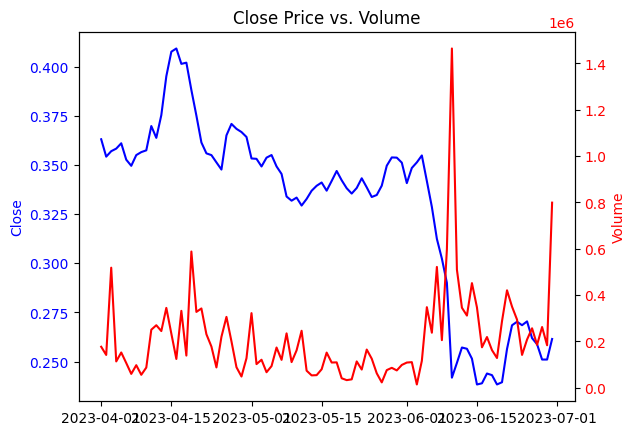

In [26]:
# Downsample the data to not crash the plotting mechanism, we don't need to plot everything in the dataset
downsampled_df = df.resample('1D').mean()

# close price to the left y axis
plt.plot(downsampled_df.index, downsampled_df['close'], label='Close', color='blue')
plt.ylabel('Close', color='blue')
plt.tick_params(axis='y', labelcolor='blue')

# duplicate to get a second y axis on the right and plot the volune
ax2 = plt.twinx()
ax2.plot(downsampled_df.index, downsampled_df['volume'], label='Volume', color='red')
ax2.set_ylabel('Volume', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Close Price vs. Volume')
plt.show()


# Run

## Reset Model Stats
This create a stats and metrics placeholder. If you want to compare different setups, do not reset this dict.

In [27]:
all_model_stats = {}

## Set Hyperparams
If you want to compare different setup, start at this point. Every try will be identified by the hyper parameters you set here. 

In [29]:
hidden_units = 64 # the amount of internal memory cells of our model, imagine they are small little algorithsm, helping the model to learn
num_layers = 4 # the amount of layers in the model, where each layer contains its own memory cells
learning_rate = 0.001 # the amount the model adapts it's weights and biases (parameters) after every step
learning_rate_step_size=5 # after how many steps should the learning rate be de- or increased?
learning_rate_gamma=0.9 # that's the multiplier to manipulate the learning rate
num_epochs = 300 # how many times (steps) our main loop will go through the training process?
batch_size = 32 # how many data will we process at once?
window_size = 14  # how many data points in the past to look at for our prediction
prediction_steps = 7 # how many data points to skip until the data point that we want to predict
dropout_rate = 0.2 # how many nodes in the model to set to zero

sample_size = 1000

features = ['close', 'volume', 'trades'] # what columns to use 
target = 'close' # what column to predict

## Prepare Data
### Dummy Data
If we want to test everything with "simple" fake data, we can use the following dummy data set. If not, just skip it. 

In [11]:
num_rows = 1000
data = {
    'close': ([1] * window_size + [2] * (prediction_steps - 1) + [3]) * num_rows,
    'volume': [4] * num_rows * (window_size + prediction_steps),
    'trades': [8] * num_rows * (window_size + prediction_steps)
}
df = pd.DataFrame(data)
df.head(window_size + prediction_steps)

,close,volume,trades
0,1,4,8
1,1,4,8
2,1,4,8
3,1,4,8
4,1,4,8
5,1,4,8
6,1,4,8
7,1,4,8
8,1,4,8
9,1,4,8


# Sample, Normalize, Batch and Split
Finally, this part samples the data, nornalizes it, creates batches and training and testing splits. 

In [31]:
# right now start with a small sample, as soon as we have enough computing power, we can skip this step
df_sampled = df[features].head(sample_size).copy()

#scaler = MinMaxScaler() # MinMax would work, too, but in fact a stock price has not really "min/max values", except the 0 ;)
scaler = StandardScaler()

# Extract the selected features and transform them
selected_features = df_sampled[features].values.reshape(-1, len(features))
scaled_features = scaler.fit_transform(selected_features)

# Replace the original features with the scaled features in the DataFrame
df_sampled[features] = scaled_features

# MERGING
X, y = create_sequences(df_sampled, window_size, prediction_steps, features, target)

# SPLITTING
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# BATCHING
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Shuffling is set to "True", if you want to reproduce results, it may help to set shuffle to False
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Validation
You don't need this step,it just helps you to reproduce the previous step. This part bascial reverts normalizing, batching and splitting.

In [32]:
# Inverse transform the first set of features and label from the train dataset
first_train_batch = next(iter(train_dataloader))
X_train_batch, y_train_batch = first_train_batch

# Convert PyTorch tensors to NumPy arrays
X_train_np = X_train_batch.numpy()
y_train_np = y_train_batch.numpy()

# Inverse transform features
denormalized_features = scaler.inverse_transform(X_train_np[0])

# Assuming 'features' contains the list of feature column names
features_df = pd.DataFrame(denormalized_features, columns=features)

# Inverse transform the label
label_idx = list(df_sampled.columns).index('close')  # Get the index of the label column
reshaped_label = y_train_np[0]  # No indexing needed for a scalar label
denormalized_label = scaler.inverse_transform([[reshaped_label, 0, 0]])[0][0]

# Create a DataFrame for the label
label_df = pd.DataFrame({'close': [denormalized_label]})

result_df = pd.concat([features_df, label_df], axis=1)

# Format columns (assuming 'decimal_col' contains columns needing decimal formatting and 'thousand_col' contains columns needing thousand formatting)
result_df['close'] = result_df['close'].applymap(lambda x: "{:.8f}".format(x))
result_df['volume'] = result_df['volume'].apply(lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x)
result_df['trades'] = result_df['trades'].apply(lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x)

result_df


/var/folders/qs/17jkqdy56fzbw44wlzm2j3gr0000gn/T/ipykernel_35885/1687572457.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_df['close'] = result_df['close'].applymap(lambda x: "{:.8f}".format(x))


,close,volume,trades,close
0,0.38819999,"743,023",481,0.39156500
1,0.38479999,"273,027",167,nan
2,0.38624901,"45,507",70,nan
3,0.38523000,"56,507",99,nan
4,0.38659599,"407,165",356,nan
5,0.39498201,"1,353,866",525,nan
6,0.39346999,"163,572",131,nan
7,0.39573801,"404,816",289,nan
8,0.39902601,"93,681",133,nan
9,0.39881301,"342,331",304,nan


In [33]:
df.head(window_size + prediction_steps)

,timestamp,open,high,low,close,volume,trades
date,,,,,,,
2023-04-01 00:00:00,1680307200,0.367714,0.368975,0.363837,0.364887,1.321380e+05,109
2023-04-01 01:00:00,1680310800,0.364344,0.365509,0.364067,0.365439,1.032764e+04,30
2023-04-01 02:00:00,1680314400,0.365319,0.368455,0.365161,0.368455,2.693093e+04,30
2023-04-01 03:00:00,1680318000,0.368617,0.368617,0.366182,0.367340,3.077013e+04,29
2023-04-01 04:00:00,1680321600,0.367187,0.371233,0.366914,0.370212,2.045499e+04,35
2023-04-01 05:00:00,1680325200,0.370329,0.370329,0.365156,0.365684,7.861893e+04,88
2023-04-01 06:00:00,1680328800,0.365600,0.365601,0.359475,0.363322,1.510096e+06,420
2023-04-01 07:00:00,1680332400,0.363122,0.363270,0.360851,0.360851,3.132304e+05,802
2023-04-01 08:00:00,1680336000,0.360724,0.361650,0.359989,0.360058,9.953546e+04,132


## Init the Model and Metric Functions
This is where you set up the three most important things: The model itself, the loss function and the optimizer.

In [34]:
# Initialize the model, loss function, and optimizer
#model_1 = PricePredictionLSTM(input_size=len(features), hidden_size=hidden_units, num_layers=num_layers)
#model_1 = ImprovedPricePredictionLSTM(input_size=len(features), hidden_size=hidden_units, num_layers=num_layers, dropout = dropout_rate)
#model_1 = PricePredictionGRU(input_size=len(features), hidden_size=hidden_units, num_layers=num_layers)
model_1 = ImprovedPricePredictionGRU(input_size=len(features), hidden_size=hidden_units, num_layers=num_layers, dropout = dropout_rate)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
#optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate)
#optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_gamma)  # Adjust step_size and gamma as needed

## Train/Test Loop
### Model Stats Preparation
This part prepares the model stats. It's here to help you comparing different setups. Run this if you switched to a different model or changed the hyper parameters.

In [35]:
current_model_stats = {
        'name': model_1.__class__.__name__,
        'device': device,
        'optimizer': optimizer.__class__.__name__,
        'sample_size': sample_size,
        'hidden_units': hidden_units,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'window_size': window_size,
        'prediction_steps': prediction_steps,
        'dropout_rate': dropout_rate,
        'duration': 0,
        'epochs': [],
        'train_loss_values': [],
        'test_loss_values': [],
        'train_rmse_values': [],
        'test_rmse_values': []
        }

current_model_id = current_model_stats['name'] \
        , current_model_stats['device'] \
        , current_model_stats['optimizer']  \
        , current_model_stats['sample_size']  \
        , current_model_stats['hidden_units']  \
        , current_model_stats['num_layers']  \
        , current_model_stats['learning_rate']  \
        , current_model_stats['batch_size']  \
        , current_model_stats['window_size']  \
        , current_model_stats['prediction_steps']  \
        , current_model_stats['dropout_rate']

current_model_id = '|'.join(map(str, current_model_id))

if current_model_id in all_model_stats:
        last_record = all_model_stats[current_model_id]

        current_model_stats = {
                'name': model_1.__class__.__name__,
                'device': device,
                'optimizer': optimizer.__class__.__name__,
                'sample_size': sample_size,
                'hidden_units': hidden_units,
                'num_layers': num_layers,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'window_size': window_size,
                'prediction_steps': prediction_steps,
                'dropout_rate': dropout_rate,
                'duration': last_record['duration'],
                'epochs': last_record['epochs'],
                'train_loss_values': last_record['train_loss_values'],
                'test_loss_values': last_record['test_loss_values'],
                'train_rmse_values': last_record['train_rmse_values'],
                'test_rmse_values': last_record['test_rmse_values']
        }

current_model_id

'ImprovedPricePredictionGRU|mps|Adam|1000|64|4|0.001|32|14|7|0.2'

### Run the loop
Finally, this part will start optimization and training! Run it as often as you want, results will be summed up!

In [36]:
start = time.time()

epoch_count = current_model_stats['epochs']
start_epoch = 0 if len(epoch_count) == 0 else epoch_count[-1] # helpful if you start over this particular cell

for epoch in tqdm(range(start_epoch, start_epoch + num_epochs)): # tqdm is our progress bar wrapper

    model_1.train() # activate training mode

    # handle loss monitoring
    total_train_loss = 0.0
    all_train_targets = []
    all_train_outputs = []
    
    # process batches in the training dataloader
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        
        outputs = model_1(inputs) # calculate predictions
        loss = loss_fn(outputs.squeeze(), targets) # calculat the loss
        optimizer.zero_grad() # reset gradients
        loss.backward() # backward propagation
        optimizer.step() # update parameters
        
        total_train_loss += loss.item()

        all_train_targets.extend(targets.numpy())
        all_train_outputs.extend(outputs.detach().numpy())

    # scheduler.step()

    model_1.eval() # activate eval mode

    # handle loss monitoring
    total_test_loss = 0.0
    all_test_targets = []
    all_test_outputs = []

    # process batches in the testing dataloader
    for i, (inputs, targets) in enumerate(test_dataloader):
        with torch.inference_mode(): # activate inference mode/no grad
            outputs = model_1(inputs) # calculate predictions
            loss = loss_fn(outputs.squeeze(), targets) # calculate loss

            # monitor loss
            total_test_loss += loss.item()
            all_test_targets.extend(targets.numpy())
            all_test_outputs.extend(outputs.detach().numpy())

    # calculate average epoch losses
    average_epoch_train_loss = total_train_loss / len(train_dataloader)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)
    
    # caculate accuracy
    train_rmse = math.sqrt(mean_squared_error(all_train_targets, all_train_outputs))
    test_rmse = math.sqrt(mean_squared_error(all_test_targets, all_test_outputs))

    # VISUALIZE
    current_model_stats['epochs'].append(epoch)
    current_model_stats['train_loss_values'].append(average_epoch_train_loss)
    current_model_stats['test_loss_values'].append(average_epoch_test_loss)
    current_model_stats['train_rmse_values'].append(train_rmse)
    current_model_stats['test_rmse_values'].append(test_rmse)

    # LOG
    if epoch % int(num_epochs / 10) == 0 or epoch == num_epochs - 1:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}], "
        f"Train Loss: {average_epoch_train_loss:.4f} | "
        f"Test Loss: {average_epoch_test_loss:.4f} | "
        f"Train RMSE: {train_rmse:.4f} | "
        f"Test RMSE: {test_rmse:.4f} | "
        f"Current LR: {current_lr:.8f} | "
        f"Duration: {time.time() - start:.0f} seconds")

current_model_stats['duration'] += time.time() - start

all_model_stats[current_model_id] = current_model_stats

  0%|          | 1/300 [00:00<02:29,  2.00it/s]

Epoch [1/300], Train Loss: 0.2787 | Test Loss: 0.1870 | Train RMSE: 0.5316 | Test RMSE: 0.4311 | Current LR: 0.00100000 | Duration: 1 seconds


 10%|█         | 31/300 [00:15<02:16,  1.97it/s]

Epoch [31/300], Train Loss: 0.0754 | Test Loss: 0.1546 | Train RMSE: 0.2755 | Test RMSE: 0.3940 | Current LR: 0.00100000 | Duration: 15 seconds


 20%|██        | 61/300 [00:29<01:53,  2.11it/s]

Epoch [61/300], Train Loss: 0.0325 | Test Loss: 0.3264 | Train RMSE: 0.1800 | Test RMSE: 0.5621 | Current LR: 0.00100000 | Duration: 30 seconds


 30%|███       | 91/300 [00:43<01:35,  2.18it/s]

Epoch [91/300], Train Loss: 0.0128 | Test Loss: 0.4485 | Train RMSE: 0.1135 | Test RMSE: 0.6571 | Current LR: 0.00100000 | Duration: 44 seconds


 40%|████      | 121/300 [00:57<01:29,  2.00it/s]

Epoch [121/300], Train Loss: 0.0066 | Test Loss: 0.4404 | Train RMSE: 0.0812 | Test RMSE: 0.6523 | Current LR: 0.00100000 | Duration: 58 seconds


 50%|█████     | 151/300 [01:12<01:13,  2.04it/s]

Epoch [151/300], Train Loss: 0.0052 | Test Loss: 0.4863 | Train RMSE: 0.0722 | Test RMSE: 0.6816 | Current LR: 0.00100000 | Duration: 72 seconds


 60%|██████    | 181/300 [01:27<01:02,  1.92it/s]

Epoch [181/300], Train Loss: 0.0053 | Test Loss: 0.4686 | Train RMSE: 0.0728 | Test RMSE: 0.6705 | Current LR: 0.00100000 | Duration: 87 seconds


 70%|███████   | 211/300 [01:41<00:42,  2.07it/s]

Epoch [211/300], Train Loss: 0.0053 | Test Loss: 0.5120 | Train RMSE: 0.0719 | Test RMSE: 0.7005 | Current LR: 0.00100000 | Duration: 102 seconds


 80%|████████  | 241/300 [01:56<00:30,  1.94it/s]

Epoch [241/300], Train Loss: 0.0042 | Test Loss: 0.5082 | Train RMSE: 0.0651 | Test RMSE: 0.6987 | Current LR: 0.00100000 | Duration: 116 seconds


 90%|█████████ | 271/300 [02:13<00:17,  1.69it/s]

Epoch [271/300], Train Loss: 0.0041 | Test Loss: 0.5189 | Train RMSE: 0.0631 | Test RMSE: 0.7034 | Current LR: 0.00100000 | Duration: 134 seconds


100%|██████████| 300/300 [02:28<00:00,  2.03it/s]

Epoch [300/300], Train Loss: 0.0043 | Test Loss: 0.5207 | Train RMSE: 0.0649 | Test RMSE: 0.7080 | Current LR: 0.00100000 | Duration: 148 seconds


# Validate and Visualize
This part will load some data points from our original data frame, normalize the data, run it throuhg the trained model and then denormalize it to compare the predicted values to the actual values.

In [37]:
validation_size = 10000
# df_validation = df[features].head(window_size + prediction_steps).copy() just test one window
df_validation = df[features].head(validation_size).copy()

# actuall we don't need to re-initialize the scaler again
# scaler = MinMaxScaler() 
# scaler = StandardScaler()

# Extract the selected features and transform them
selected_features = df_validation[features].values.reshape(-1, len(features))
scaled_features = scaler.fit_transform(selected_features)

# Replace the original features with the scaled features in the DataFrame
df_validation[features] = scaled_features

# MERGING
X_validate, y_validate = create_sequences(df_validation, window_size, prediction_steps, features, target)

# BATCHING
# Convert NumPy arrays to PyTorch tensors
X_validate_tensor = torch.Tensor(X_validate)
y_validate_tensor = torch.Tensor(y_validate)

model_1.eval()
# Iterate over the test DataLoader to generate predictions
with torch.inference_mode():
    output = model_1(X_validate_tensor)

predicted_array = np.array(output).reshape(-1, 1)
dummy_columns = np.zeros((predicted_array.shape[0], 2))  # Assuming 2 dummy columns
predicted_array_with_dummy = np.concatenate((predicted_array, dummy_columns), axis=1)
predicted_close_with_dummy = scaler.inverse_transform(predicted_array_with_dummy)
predicted_close = predicted_close_with_dummy[:, :-2]  # Remove the last two columns
predicted_close

array([[0.34840065],
       [0.34599851],
       [0.34679911],
       ...,
       [0.3020625 ],
       [0.30518039],
       [0.30762041]])

In [38]:
df[['close', 'volume', 'trades']].head(window_size + prediction_steps)

,close,volume,trades
date,,,
2023-04-01 00:00:00,0.364887,1.321380e+05,109
2023-04-01 01:00:00,0.365439,1.032764e+04,30
2023-04-01 02:00:00,0.368455,2.693093e+04,30
2023-04-01 03:00:00,0.367340,3.077013e+04,29
2023-04-01 04:00:00,0.370212,2.045499e+04,35
2023-04-01 05:00:00,0.365684,7.861893e+04,88
2023-04-01 06:00:00,0.363322,1.510096e+06,420
2023-04-01 07:00:00,0.360851,3.132304e+05,802
2023-04-01 08:00:00,0.360058,9.953546e+04,132


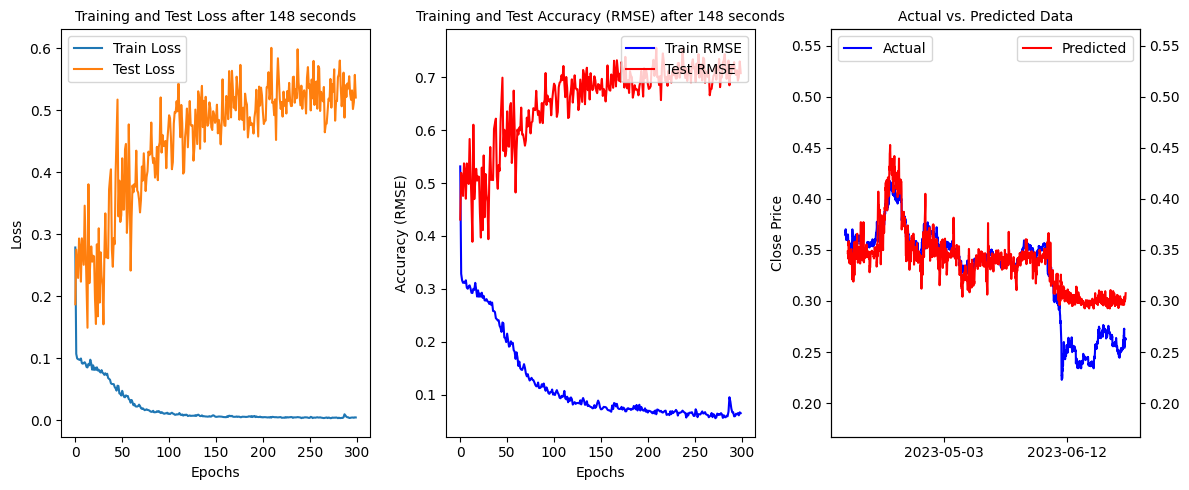

In [39]:
plt.figure(figsize=(12, 5))

# PLOT LOSS
plt.subplot(1, 3, 1)
plt.plot(epoch_count, current_model_stats['train_loss_values'], label='Train Loss')
plt.plot(epoch_count, current_model_stats['test_loss_values'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Loss after {current_model_stats["duration"]:.0f} seconds', fontsize=10)
plt.legend()

# PLOT RMSE
plt.subplot(1, 3, 2)
plt.plot(epoch_count, current_model_stats['train_rmse_values'], label='Train RMSE', color='blue')
plt.plot(epoch_count, current_model_stats['test_rmse_values'], label='Test RMSE', color='red')

plt.ylabel('Accuracy (RMSE)')
plt.xlabel('Epochs')
plt.title(f'Training and Test Accuracy (RMSE) after {current_model_stats["duration"]:.0f} seconds', fontsize=10)
plt.legend(loc='upper right')

# PLOT PREDICTIONS
df_visualize = df.head(validation_size).copy()
y_axis_max = max(np.amax(predicted_close), max(df_visualize['close'])) * 1.25
y_axis_min = min(np.amin(predicted_close), min(df_visualize['close'])) * 0.75

plt.subplot(1, 3, 3)

plt.plot(df_visualize.index, df_visualize['close'], label='Actual', color='blue')
plt.ylabel('Close Price')
plt.legend()
plt.legend(loc='upper left')
plt.ylim(y_axis_min, y_axis_max) 

plt.twinx()  # Create a second y-axis sharing the same x-axis

nan_values = np.full(window_size + prediction_steps - 1, np.nan)
predicted_close_with_nan = np.concatenate([nan_values, predicted_close.ravel()])

plt.plot(df_visualize.index, predicted_close_with_nan, label='Predicted', color='red')
plt.ylim(y_axis_min, y_axis_max) 

plt.xlabel('Time')
plt.title('Actual vs. Predicted Data', fontsize=10)

# Set different y-axis for actual and predicted data
ax2.set_ylabel('Predicted Data')

# Adjust x-axis ticks and labels for better readability
plt.xticks(fontsize=8)  # Set font size for x-axis ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))  # Set the number of ticks (change nbins as needed)
plt.legend()
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Compare

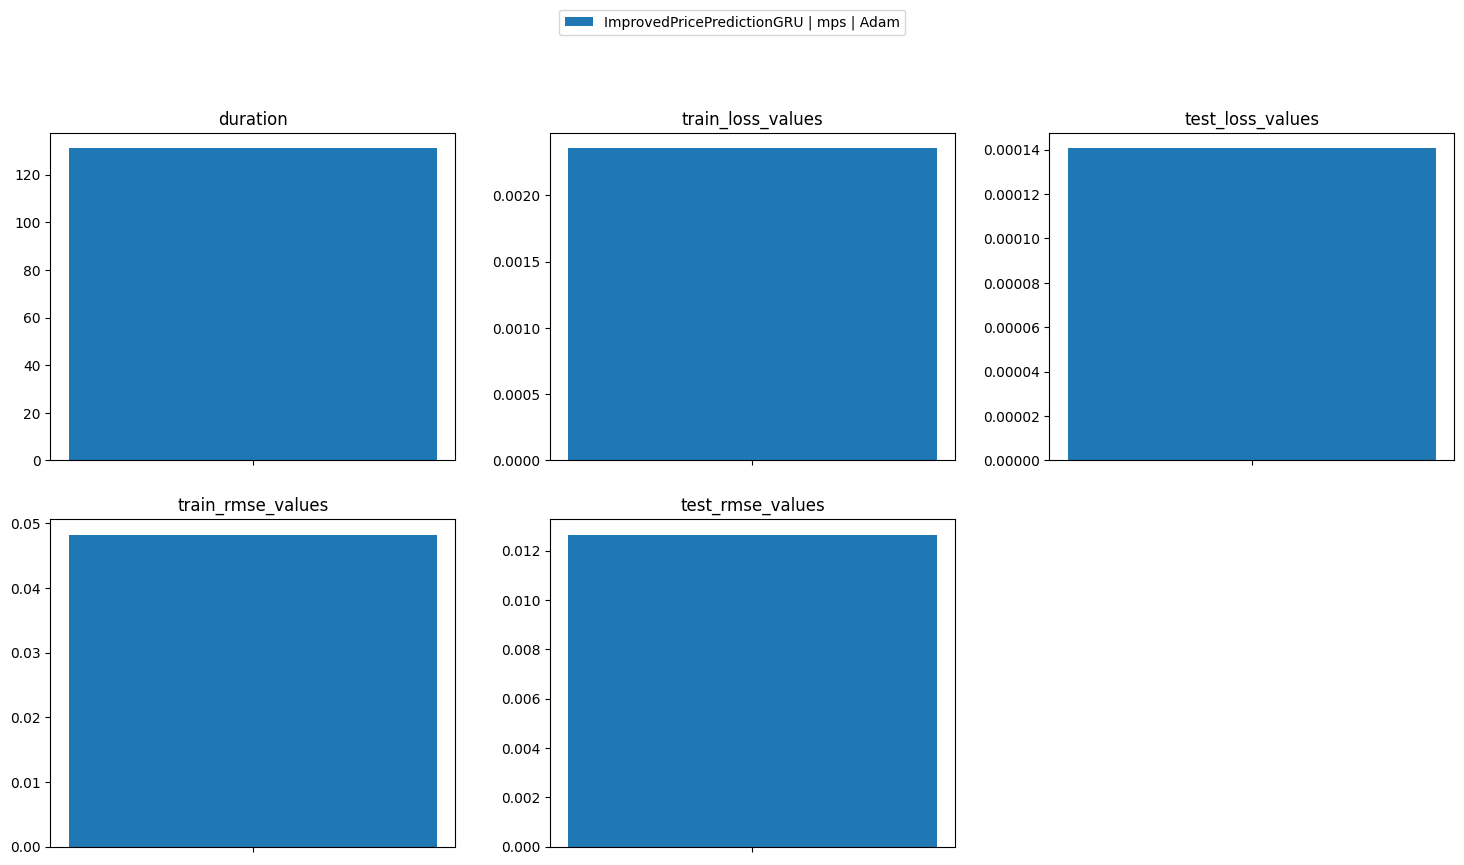

In [21]:
df_compare = model_metrics_to_dataframe(all_model_stats)
df_compare

# only plot numerical columns
numeric_cols = df_compare.select_dtypes(include=['int64', 'float64'])
numeric_cols.drop(columns=['sample_size', 'num_layers', 'epochs', 'hidden_units', 'learning_rate', 'batch_size', 'window_size', 'dropout_rate', 'prediction_steps'], inplace=True, axis=1)

num_attributes = len(numeric_cols.columns)
num_plots_per_row = 3
num_rows = (num_attributes + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(15, num_rows * 4))

for i, col in enumerate(numeric_cols.columns):
    ax = axes[i // num_plots_per_row, i % num_plots_per_row]
    labels = []
    for j, (_, row) in enumerate(df_compare.iterrows()):
        value = row[col]
        labels.append(f"{row['name']} | {row['device']} | {row['optimizer']}")
        ax.bar(j, value)
    ax.set_title(f'{col}')
    ax.set_xticks(np.arange(len(df_compare)))
    ax.set_xticklabels([])

# Remove empty subplot(s)
if num_attributes % num_plots_per_row != 0:
    for i in range(num_attributes % num_plots_per_row, num_plots_per_row):
        fig.delaxes(axes[num_attributes // num_plots_per_row, i])

#plt.subplots_adjust(wspace=0.4, hspace=0.4, top=2) 

#plt.subplots_adjust(top=0.9)  #
# Show a single legend
fig.legend(labels, bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3)

plt.tight_layout(pad=2)
plt.show()

In [1007]:
df_compare

,name,device,optimizer,sample_size,hidden_units,num_layers,learning_rate,batch_size,window_size,prediction_steps,dropout_rate,duration,epochs,train_loss_values,test_loss_values,train_rmse_values,test_rmse_values
0,PricePredictionLSTM,cpu,RMSprop,500,64,4,0.001,32,14,7,0.2,39.561260,297,0.002887,0.107206,0.053732,0.327423
0,PricePredictionLSTM,cpu,AdamW,500,64,4,0.001,32,14,7,0.2,42.559475,297,0.001158,0.123340,0.034028,0.351198
0,ImprovedPricePredictionGRU,cpu,AdamW,1000,64,4,0.001,32,14,7,0.2,311.307015,299,0.003490,0.000997,0.059379,0.033175
0,ImprovedPricePredictionGRU,cpu,Adam,1000,64,4,0.001,32,14,1,0.2,305.854322,299,0.002493,0.016348,0.050086,0.125324
0,ImprovedPricePredictionGRU,cpu,Adam,1000,64,4,0.001,32,14,7,0.2,324.062447,299,0.001976,0.066629,0.044529,0.273827


# Save/Load
There are a couple of ways to safe a model. Sometimes you will find the pickle-method, that just dumps the whole model into a pickel file. Or you use the `state_dict()` method that puts the parameters into a file. If you load the state back, you need to init the model first with the according model class.
### Export/Import of the full model

In [928]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

In [931]:
MODEL_NAME = "model_1.pkl"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(model_1, f)

with open(MODEL_SAVE_PATH, 'rb') as f:
     model_1_loaded = pickle.load(f)

model_1_loaded.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 1.6797e-03,  2.0946e-01,  7.6561e-02],
                      [ 7.9508e-03,  6.5301e-02, -1.1698e-01],
                      [ 2.0817e-01,  9.0213e-02,  4.9732e-03],
                      [-9.3729e-02,  4.0206e-02, -4.8198e-03],
                      [-1.8047e-01, -1.3749e-02,  1.0526e-01],
                      [-2.1820e-02, -1.3439e-01, -5.1197e-02],
                      [ 1.2938e-01, -6.4604e-02, -6.4203e-02],
                      [ 1.2696e-01,  5.0766e-02,  5.7282e-02],
                      [ 9.5209e-02,  5.8107e-02, -3.3907e-04],
                      [ 3.1968e-01, -1.9646e-01, -2.9894e-01],
                      [-3.3644e-02, -7.4706e-02,  8.9448e-02],
                      [-7.8604e-02,  3.5270e-01,  3.1171e-01],
                      [ 3.1713e-02,  3.9900e-02,  6.1958e-02],
                      [ 8.0895e-02,  1.1082e-01,  1.0013e-01],
                      [ 2.1395e-02,  6.4351e-03,  6.5978e-02],
                    

### Export/Import of the Model's State

In [923]:
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)
model_1_loaded = PricePredictionLSTM(input_size=len(features), hidden_size=hidden_units, num_layers=num_layers)
model_1_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_1_loaded.to(device)
model_1_loaded.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 1.6797e-03,  2.0946e-01,  7.6561e-02],
                      [ 7.9508e-03,  6.5301e-02, -1.1698e-01],
                      [ 2.0817e-01,  9.0213e-02,  4.9732e-03],
                      [-9.3729e-02,  4.0206e-02, -4.8198e-03],
                      [-1.8047e-01, -1.3749e-02,  1.0526e-01],
                      [-2.1820e-02, -1.3439e-01, -5.1197e-02],
                      [ 1.2938e-01, -6.4604e-02, -6.4203e-02],
                      [ 1.2696e-01,  5.0766e-02,  5.7282e-02],
                      [ 9.5209e-02,  5.8107e-02, -3.3907e-04],
                      [ 3.1968e-01, -1.9646e-01, -2.9894e-01],
                      [-3.3644e-02, -7.4706e-02,  8.9448e-02],
                      [-7.8604e-02,  3.5270e-01,  3.1171e-01],
                      [ 3.1713e-02,  3.9900e-02,  6.1958e-02],
                      [ 8.0895e-02,  1.1082e-01,  1.0013e-01],
                      [ 2.1395e-02,  6.4351e-03,  6.5978e-02],
                    